# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System
<br/>
<br/>
File:    app_neiss_hospital_injuries.ipynb<br/>
Author:  Martin Corbett<br/>
Copyright:  (c) 2019 All rights reserved, worldwide.<br/>
<br/>
<br/>
- The datafiles can be downloaded from:  https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx
<br/>
<br/>
"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."
<br/>
<br/>
https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss<br/><br/>
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx<br/><br/>



In [1]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import graphviz
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, fixed
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import metrics
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn.feature_selection import SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
import sys
from time_based_graphs import *
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
class Includes():
    TimeBasedGraphs = True
    PearsonChiSquared = True
    PythonCorr = True
    LinearRegressionChi2 = True
    LogisticRegression = True
    GaussianNB = True
    DecisionTree = True
    LdaSvmPipeline = True
    



- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

convert_neiss_original_data_to_pckl.ipynb is used to create the pickled file




### Note:  The pckl file is expected to be found in the _IPYNB___DIRECTORY_/data/NEISS/neiss_data.pckl

In [4]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception(
        'ERROR:  {} does not exist\n  Use "convert_neiss_original_data_to_pckl.ipynb" to create the pckl file'.format(
            pckl_fname))


Reading /Users/mcorbett/Boston University/MET_CS677_DataScienceWithPython/Project/data/NEISS/neiss_data.pckl  ... done!


In [5]:
dfNeiss.shape

(7352927, 19)

In [6]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


### Update Neiss with column code dictionary from Excel file

In [7]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [8]:
neiss = Neiss(dfNeiss)

In [9]:
dfNeiss.shape

(7352927, 19)

## Build a categorical dataframe (with a subset of the overall data 3000 random rows)

The dataframe is built of columns that are only categorical in nature.

In [10]:
class DataFramePruner():
    def __init__(self, dict_prune=dict(), max_output_rows=None, keep_end=True):
        '''
        Prune a dataframe based on a dictionary and the maximum number of output rows
        
        Args:
          dict_prune  (dict):  Of the form {col_name : max_output_categories, ...}
          max_output_rows (int):  If none, all rows are kept.  Otherwise, the dataframe is clipped to this number of rows maximum.
          keep_end (bool):  True, max_output_rows is relative to the end of the dataframe.  False, from beginning.
        '''
        self.dict_prune = dict_prune
        self.max_output_rows = max_output_rows
        self.keep_end = keep_end

    def _limitColumnCategoriesTo(df, column_name, num_categories):
        '''
         Get the top 'num_categories' most frequent names in self.df[column_name]

         Args:
             column_name (str):  The name of the column to limit the categories on
             num_categories (int):  The maximum number of unique values to retain in 'column_name'
        '''
        selected = df[column_name].value_counts()[:num_categories].index.tolist()
        return df[df[column_name].isin(selected)]

    def prune(self, df):
        for column_name in self.dict_prune.keys():
            df = DataFramePruner._limitColumnCategoriesTo(df, column_name, self.dict_prune[column_name])

        if None != self.max_output_rows:
            if True == self.keep_end:
                df = df[-self.max_output_rows : ]
            else:
                df = df[0 : self.max_output_rows]

        return df


In [11]:
class NeissSubset():
    def __init__(self, df, categories, dataframe_pruner=None):
        self.df = df.copy()
        self.categories = categories.copy()

        self.df = self.df.xs(self.categories, axis=1)
        self.df.dropna(inplace=True)
        self.df['Race'] = [int(x) for x in self.df['Race']]
        
        if None != dataframe_pruner:
            self.df = dataframe_pruner.prune(self.df)

        self.updateCodeIdVariables()

    def updateCodeIdVariables(self):
        # Get the code ID translator for the dataframe
        self.codeIdTranslator = CodeIdTranslatorDataFrame(self.df, self.categories)
        self.codeIdTranslator.transformColumns()

        # Get the code ID translators for the dataframe
        currentState = self.codeIdTranslator.getState()

        self.codeIdTranslator.setState('id')
        self.dfIdToCode = self.codeIdTranslator.getDataFrame().copy()

        self.codeIdTranslator.setState('code')
        self.dfCodeToId = self.codeIdTranslator.getDataFrame().copy()

        self.codeIdTranslator.setState(currentState)

    def limitColumnCategoriesTo(self, column_name, num_categories):
        '''
         Get the top 'num_categories' most frequent names in self.df[column_name]
         
         Args:
             column_name (str):  The name of the column to limit the categories on
             num_categories (int):  The maximum number of unique values to retain in 'column_name'
        '''
        selected = self.df[column_name].value_counts()[:num_categories].index.tolist()
        self.df = self.df[self.df[column_name].isin(selected)]
        #self.updateCodeIdVariables()

    def limitMaxRowsTo(self, num_rows):
        self.df = self.df.sample(num_rows)
        #self.updateCodeIdVariables()

    def getDataFrame(self):
        return self.df

    def getCategories(self):
        return self.categories
    
    def getCodeIdTranslator(self):
        return self.codeIdTranslator
    
    def getIdToCodeDataframe(self):
        return self.dfIdToCode
    
    def getCodeToIdDataframe(self):
        return self.dfCodeToId

In [12]:
output_choice = 'Diagnosis'

max_output_rows = 1000000
pruner = DataFramePruner(dict_prune={output_choice : 10}, max_output_rows=max_output_rows, keep_end=True)

neissSubset = NeissSubset(dfNeiss,
    categories=['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
    'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ],
    dataframe_pruner=pruner)

In [13]:
neissSubset.getDataFrame().shape

(1000000, 11)

In [14]:
neissSubset.getDataFrame().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
33328,3,2,16,10,1,9,1,396,1,17,4
33329,3,2,5,5,1,2,1,580,1,17,4
33331,3,2,9,10,1,2,1,165,1,17,4
33332,2,2,6,2,1,2,1,79,1,17,4
33333,2,2,11,4,1,2,1,519,1,17,4


## Show the IdToCode and CodeToId translators for the neissSubset dataframe

In [15]:
neissSubset.getIdToCodeDataframe().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
33328,3,2,16,10,1,9,1,396,1,17,4
33329,3,2,5,5,1,2,1,580,1,17,4
33331,3,2,9,10,1,2,1,165,1,17,4
33332,2,2,6,2,1,2,1,79,1,17,4
33333,2,2,11,4,1,2,1,519,1,17,4


In [16]:

neissSubset.getCodeToIdDataframe().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
33328,2,1,82,71,1,9,0,1290,0,19,S
33329,2,1,34,57,1,1,0,1807,0,19,S
33331,2,1,38,71,1,1,0,610,0,19,S
33332,1,1,35,53,1,1,0,374,0,19,S
33333,1,1,76,56,1,1,0,1616,0,19,S


## Show time based graphs of male/female injuries - whole dataframe used

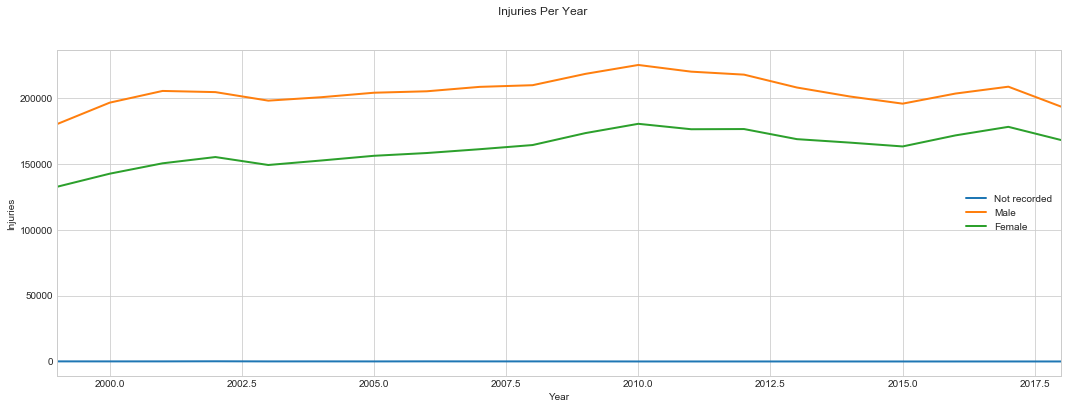

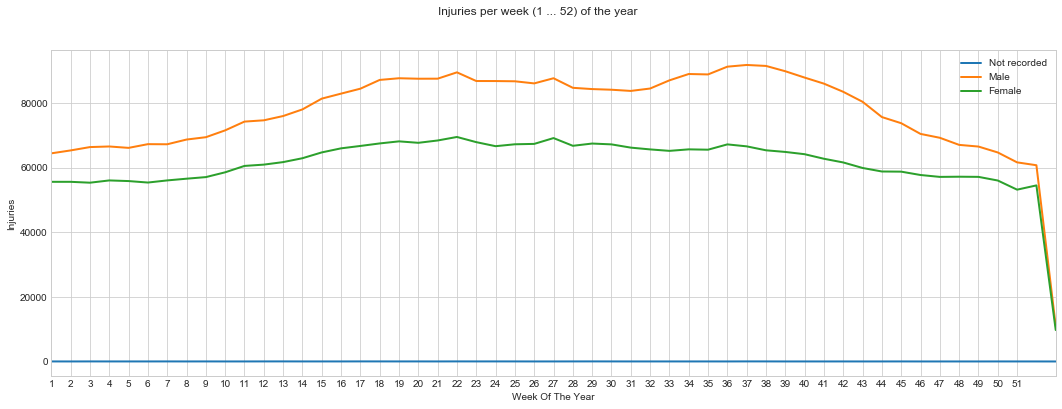

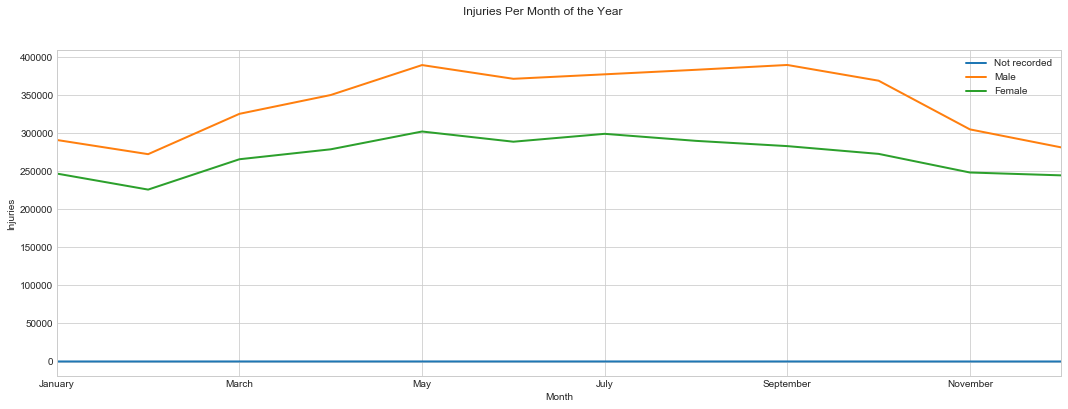

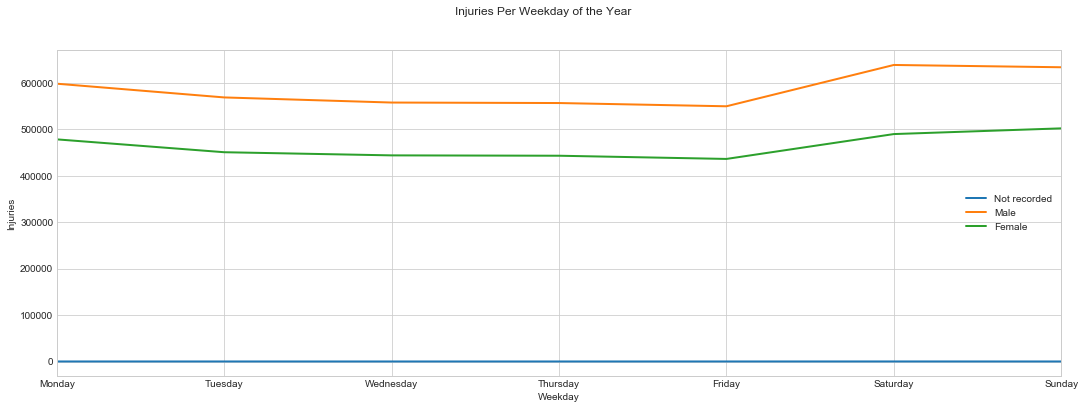

In [17]:
if True == Includes.TimeBasedGraphs:
    stat_name = 'Sex'
    date_name = 'Treatment_Date'

    TimeBasedGraphs(dfNeiss, Neiss.getColumnDictionary(stat_name), date_name, stat_name).show()


## Functions/Classes used for the python correlations and pearson chi squared correlations

In [18]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    '''
    For each column in the dataframe determine which rows equal or exceed the minimum value
    
    Args:
        df (pd.DataFrame):    The original dataframe
        dfCategoricalCorrMatrix  (list of (row_name, col_name) tuples): The categorical matrix
        minValue (int):  The value the row/column cell must equal or exceed

    Returns:
      A list of tuples containing (row, column) where the value equalled or exceeded the minimum value
    '''
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y

                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

In [19]:
class UserSelectableSwarmScatterPlots():
    def __init__(self, high_correlations, code_id_translator):
        self.button = widgets.Button(description="Click Me!")
        self.output = widgets.Output()
        self.high_correlations = high_correlations
        self.code_id_translator = code_id_translator

    def show(self):
        button = widgets.Button(description="Click Me!")
        output = widgets.Output()

        #print(self.high_correlations.values)
        select = self.high_correlations[0]
        #print(select)
        lCorrelations = ['{}, {}'.format(y, x) for y, x in self.high_correlations]
        correlationDropDownSel = widgets.Dropdown(
            options=lCorrelations,
            value=lCorrelations[0],
            description='correlations',
            disabled=False,
        )

        typeDropDownSel = widgets.Dropdown(
            options=['swarm', 'scatter'],
            value='swarm',
            description='plot_type',
            disabled=False,
        )

        wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
        wVBox = widgets.VBox([wHBox, button, output])

        display(wVBox)

        def on_button_clicked(b):
            with output:
                sel = correlationDropDownSel.value
                (xSel, ySel) = [x.strip() for x in sel.split(',')]
                print('-{}-, -{}-'.format(xSel, ySel))

                correlations(self.code_id_translator, xSel, ySel, typeDropDownSel.value)

                #sns.pairplot(dfSel, hue=xSel)

        button.on_click(on_button_clicked)

In [20]:
class CategoricalMatrixHeatMap:
    def __init__(self, title, dfCategoricalMatrix):
        self.title = title
        self.dfCategoricalMatrix = dfCategoricalMatrix

    def show(self, figsize=(10, 10)):
        fig, ax = plt.subplots(figsize=figsize)

        g = sns.heatmap(self.dfCategoricalMatrix, annot=True, linewidths=0.4, ax=ax)
        g.set_title(self.title)

        # Fix the top and bottom margins of the heatmap
        bottom_y, top_y = plt.ylim() 
        bottom_y += 0.5 
        top_y -= 0.5 
        plt.ylim(bottom_y, top_y)
        plt.show()

## Python (pandas.DataFrame.corr) - dataframe subset used

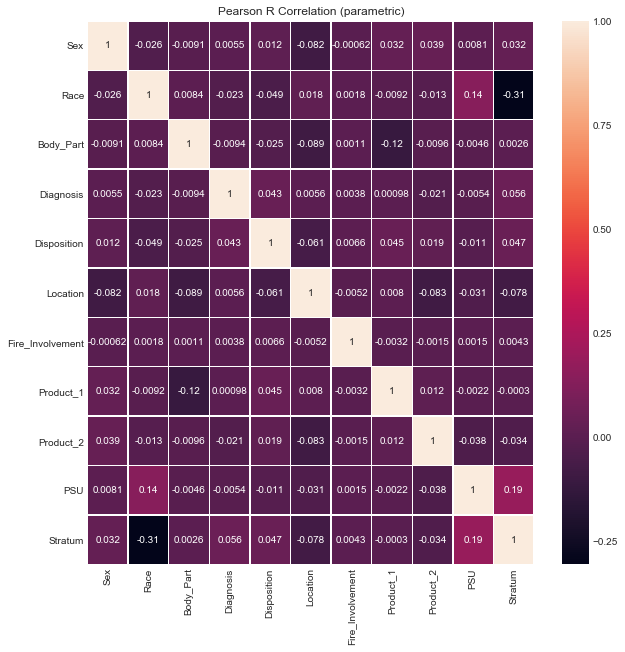

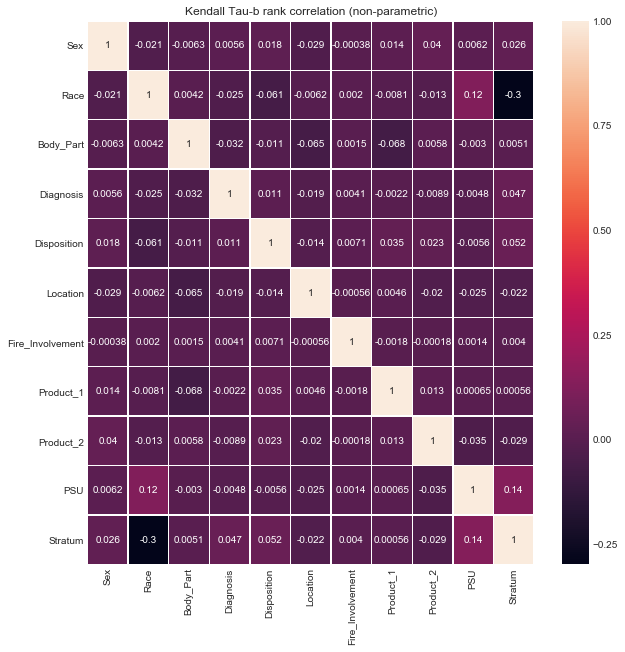

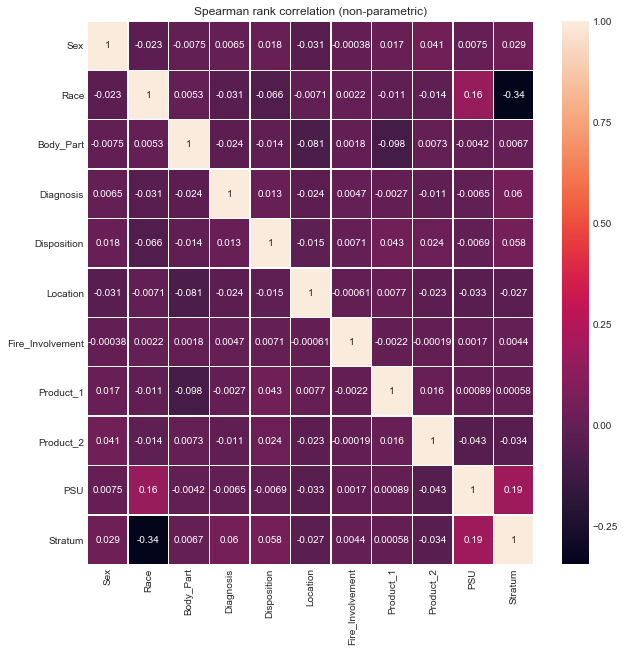

In [21]:
if True == Includes.PythonCorr:
    methods = {
        'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
            # For pearson:
            # both variables should be normally distributed
            # There should be no significant outliers
            # Each variable should be continuous
            # The two variables have a linear relationship
            # The observations are paired observations.
            # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
        'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
            # The variables are measured on an ordinal or continuous scale.
            # Desirable if your data appears to follow a monotonic relationship.
        'spearman' : 'Spearman rank correlation (non-parametric)'
            # Does not assume that both datasets are normally distributed
        }

    dfCategoricalMatrices = {}
    for key in methods.keys():
        dfCategoricalMatrices[key] = neissSubset.getDataFrame().corr(method = key)
        heatMap = CategoricalMatrixHeatMap(methods[key], dfCategoricalMatrices[key])
        heatMap.show()


In [22]:
#if True == Includes.PythonCorr:
#    for key in dfCategoricalMatrices.keys():
#        print('{}:\n{}'.format(key, dfCategoricalMatrices))
#        print()

In [23]:
if True == Includes.PythonCorr:
    highCorrelationsPythonCorr = getHighCorrelations(
        neissSubset.getDataFrame(),
        dfCategoricalMatrices['spearman'],
        0.1)

In [24]:
#if True == Includes.PythonCorr:
#    for n in highCorrelationsPythonCorr:
#        print(n)

In [25]:
if True == Includes.PythonCorr:
    plots = UserSelectableSwarmScatterPlots(highCorrelationsPythonCorr, neissSubset.getCodeIdTranslator())
    plots.show()


- Analysis: The pandas.DataFrame.corr method is not that great when used with categorical data given an output with many categories. 

## PearsonChiSquared - dataframe subset used

https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

'The Pearson’s chi-squared statistical hypothesis is an example of a test for independence between categorical variables.'

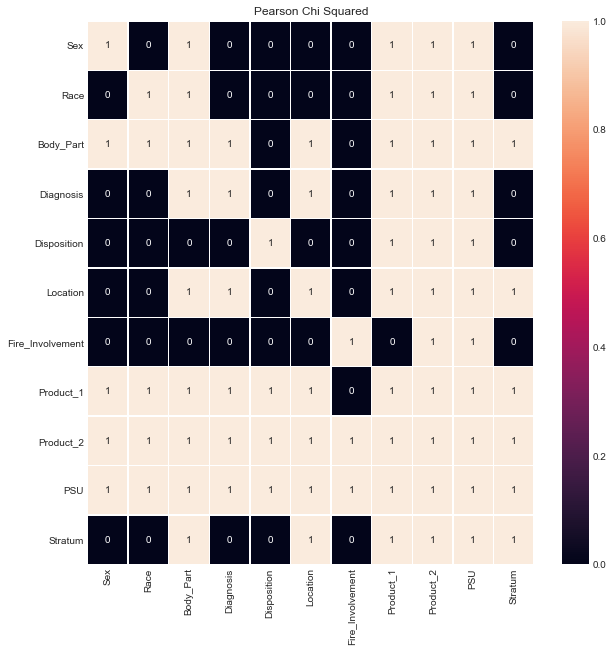

In [26]:
if True == Includes.PearsonChiSquared:
    pearsonChiSquared = PearsonChiSquared(neissSubset.getDataFrame())
    dfPersonChiSquaredCategoricalCorrMatrix = pearsonChiSquared.getCorrMatrixDataframe(neissSubset.getCategories())
    #print(dfCategoricalCorrMatrix.head())

    heatMap = CategoricalMatrixHeatMap('Pearson Chi Squared', dfPersonChiSquaredCategoricalCorrMatrix)
    heatMap.show() 

In [27]:
if True == Includes.PearsonChiSquared:
    highCorrelationsPearsonChiSquared = getHighCorrelations(
        neissSubset.getDataFrame(),
        dfPersonChiSquaredCategoricalCorrMatrix,
        0.95)

In [28]:
#if True == Includes.PearsonChiSquared:
#    for n in highCorrelationsPearsonChiSquared:
#        print(n)

In [29]:
if True == Includes.PearsonChiSquared:
    plots = UserSelectableSwarmScatterPlots(highCorrelationsPearsonChiSquared, neissSubset.getCodeIdTranslator())
    plots.show()

- Analysis:  Pearson ChiSquared is a better measure of correlation between categorical data than the three python functions shown below (used with pandas.DataFrame.corr):

    'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
    
    'kendall' : 'Kendall Tau-b rank correlation (non-parametric)'
    
    'spearman' : 'Spearman rank correlation (non-parametric)'



## Linear regression (using chi2 & KBest) - dataframe subset used

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

- f_classif:  ANOVA F-value between label/feature for classification tasks.

- mutual_info_classif: Mutual information for a discrete target.

- chi2:  Chi-squared stats of non-negative features for classification tasks.

- f_regression:  F-value between label/feature for regression tasks.

- mutual_info_regression:  Mutual information for a continuous target.
    
- SelectPercentile:  Select features based on percentile of the highest scores.

- SelectFpr:  Select features based on a false positive rate test.

- SelectFdr:  Select features based on an estimated false discovery rate.

- SelectFwe:  Select features based on family-wise error rate.

- GenericUnivariateSelect:  Univariate feature selector with configurable mode.


In [30]:
class Pruner():
    '''
    Abstract base class
    '''
    def execute(self):
        pass

class PrunerKBest(Pruner):
    def __init__(self, score_func=chi2, k_features=10):
        '''
        Select features according to the k highest scores.

        score_func (<function f_classif>): Function taking two arrays X and y, and returning a 
        pair of arrays (scores, pvalues) or a single array with scores. Default is f_classif 
        (see below “See also”). The default function only works with classification tasks.
        
        k_features (int): Number of top features to select. The “all” option bypasses selection, 
        for use in a parameter search.
        
        See also:
            f_classif: ANOVA F-value between label/feature for classification tasks.
            mutual_info_classif: Mutual information for a discrete target.
            chi2: Chi-squared stats of non-negative features for classification tasks.
            f_regression: F-value between label/feature for regression tasks.
            mutual_info_regression: Mutual information for a continuous target.
            SelectPercentile: Select features based on percentile of the highest scores.
            SelectFpr: Select features based on a false positive rate test.
            SelectFdr: Select features based on an estimated false discovery rate.
            SelectFwe: Select features based on family-wise error rate.
            GenericUnivariateSelect: Univariate feature selector with configurable mode.
        '''
        # comments from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html 

        self.k_features = k_features
        self.score_func = score_func
        self.selector = SelectKBest(score_func, k=k_features)
        

    def execute(self, inputs, output):

        columns = list(inputs.columns)
        columns.remove(output.columns)
        inputs = inputs[columns]
        self.selector.fit(inputs.values, output)
        selected_columns = np.asarray(inputs.columns)[self.selector.get_support()]
        return inputs[selected_columns]


In [31]:
if True == Includes.LinearRegressionChi2:
    class WorkingLinearRegressionChi2():
        def __init__(self, outputFeature, dfIdToCode, k_features=2):
            self.outputFeature = outputFeature
            self.dfKBest = dfIdToCode.copy()

            self.y = self.dfKBest[self.outputFeature]
            print(self.y)
            #columns = list(self.dfKBest.columns)
            #columns.remove(self.outputFeature)
            #self.X = PrunerKBest(chi2, k_features).execute(self.dfKBest[columns], self.y)
            self.X = PrunerKBest(chi2, k_features).execute(self.dfKBest, self.y.to_frame(self.outputFeature))
            
        def plot_scatter(X,Y,R=None):
            plt.scatter(X, Y, s=32, marker='o', facecolors='none', edgecolors='k')
            if R is not None:
                plt.scatter(X, R, color='red', linewidth=0.5)
            plt.show()  

        def showShape(self):
            print('X.shape={}'.format(self.X.shape))
            print()

        def showPlots(self):
            for category in self.X:
                print('x=', category)
                x = np.asarray(self.dfKBest[category]).reshape(-1, 1)
                regressor = LinearRegression(normalize=True).fit(x, self.y)
                y_pred    = regressor.predict(x)
                WorkingLinearRegressionChi2.plot_scatter(x, self.y, y_pred)
                print("R-squared score: {:.4f}".format(r2_score(self.y, y_pred)))
                print()
                print()


In [32]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2 = WorkingLinearRegressionChi2(
        output_choice,
        neissSubset.getIdToCodeDataframe(),
        k_features=5)

33328     10
33329      5
33331     10
33332      2
33333      4
          ..
361662     6
361663     5
361664     6
361665     9
361666     6
Name: Diagnosis, Length: 1000000, dtype: int64


Body_Part	Location	Product_1	Product_2	PSU

In [33]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2.showShape()

X.shape=(1000000, 5)



x= Body_Part


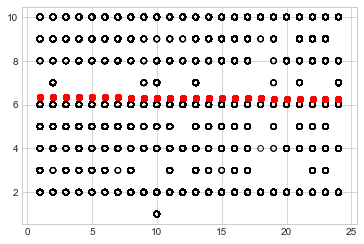

R-squared score: 0.0001


x= Location


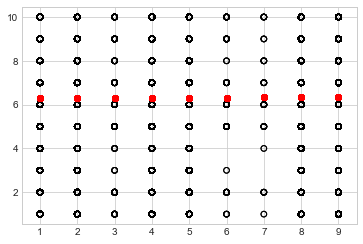

R-squared score: 0.0000


x= Product_1


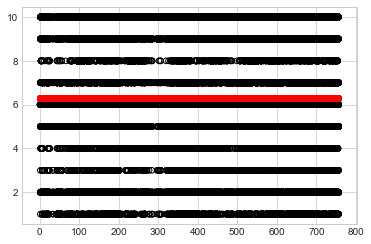

R-squared score: 0.0000


x= Product_2


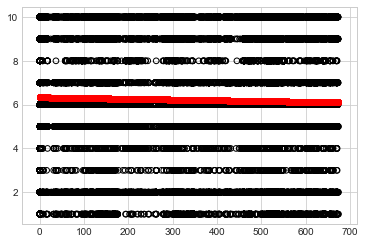

R-squared score: 0.0004


x= PSU


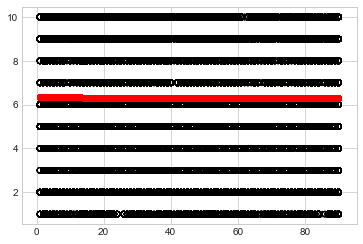

R-squared score: 0.0000




In [34]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2.showPlots()

- Analysis:  The data does not follow a linear regression model

## Logistic Regression

In [35]:
class WorkingHeatmap():
    '''
    Plots a seaborn fixing the edges of the plot
    '''

    def __init__(self, x_label, y_label,
                 title='WorkingHeatmap',
                 y_bottom_adjust=-1.5, y_top_adjust=-0.5,
                 x_left_adjust=None, x_right_adjust=None,
                 normalize_columns=False):
        self.x_label            = x_label
        self.y_label            = y_label
        self.title              = title
        self.y_bottom_adjust    = y_bottom_adjust
        self.y_top_adjust       = y_top_adjust
        self.x_left_adjust      = x_left_adjust
        self.x_right_adjust     = x_right_adjust
        self.normalize_columns  = normalize_columns

    def plot(self,
        data, vmin=None, vmax=None, cmap=None, center=None, robust=False,
        annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white',
        cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto',
        yticklabels='auto', mask=None, ax=None, **kwargs):

        if type(data) != pd.DataFrame:
            data = pd.DataFrame(data)

        dN = data
        if True == self.normalize_columns:
            dT = data.copy()
            dS = dT.sum(axis=0)[:, np.newaxis]
            dN = dT.astype('float') / dS.T.astype('float')


        g = sns.heatmap(
            dN, vmin, vmax, cmap, center, robust,
            annot, fmt, annot_kws, linewidths, linecolor,
            cbar, cbar_kws, cbar_ax, square, xticklabels,
            yticklabels, mask, ax, **kwargs)
        g.set_title(self.title)
        ax.set_xlabel(self.x_label)
        ax.set_ylabel(self.y_label)
        
        if self.y_bottom_adjust or self.y_top_adjust or self.x_left_adjust or self.x_right_adjust:

            if self.y_bottom_adjust or self.y_top_adjust:
                bottom_y, top_y = ax.get_ylim() 

                if self.y_bottom_adjust:
                    bottom_y += self.y_bottom_adjust

                if self.y_top_adjust:
                    top_y += self.y_top_adjust

                ax.set_ylim(bottom=bottom_y, top=top_y)

            if self.x_left_adjust or self.x_right_adjust:
                left_x, right_x = ax.get_xlim() 

                if self.x_left_adjust:
                    left_x += self.x_left_adjust
                    
                if self.x_right_adjust:
                    right_x += self.x_right_adjust

                ax.set_xlim(left=left_x, right=right_x)


In [36]:
if True == Includes.LogisticRegression:
    class WorkingLogisticRegression():
        '''
        Based loosly on:  https://acadgild.com/blog/logistic-regression-multiclass-classification
        '''
        def __init__(self, outputFeature, categories, dfIdToCode, codeIdTranslator, max_iter=5000):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.df = dfIdToCode.copy()
            self.codeIdTranslator = codeIdTranslator
        
            self.categories.remove(self.outputFeature)
    
            self.inputs = self.df[self.categories]
            self.output = self.df[self.outputFeature]
            
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                self.inputs, self.output, test_size=1/7.0, random_state=122)

            # Standardize the data
            scaler = StandardScaler()
            
            # Fit on training set only.
            scaler.fit(self.x_train)

            # Apply transform to both the training set and the test set.
            self.x_train = scaler.transform(self.x_train)
            self.x_test = scaler.transform(self.x_test)

            # Fit the model
            # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss.
            self.model = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', max_iter=max_iter)
            self.model.fit(self.x_train, self.y_train)

            # Validate the fitting
            # use the model to make predictions with the test data
            self.y_pred = self.model.predict(self.x_test)

            self.probs = self.model.predict_proba(self.x_test)
            test_score = self.model.score(self.x_test, self.y_test)
            print('test_score =', test_score)

            # how did our model perform?
            self.count_misclassified = (self.y_test != self.y_pred).sum()
            self.accuracy = metrics.accuracy_score(self.y_test, self.y_pred)

            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred)

            # Create predicted versus actual dataframe
            target_names = self.output.unique()

            target_dict = column_dictionary[self.outputFeature]

            dfTest = pd.DataFrame(self.y_test, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfTest, 'idToCode', self.outputFeature)
            y_test = [target_dict[x] for x in dfTest[self.outputFeature]]
            self.y_test = y_test
            #print('y_test={}'.format( np.sort(np.unique(y_test)) ))
            
            dfPred = pd.DataFrame(self.y_pred, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfPred, 'idToCode', self.outputFeature)
            y_pred = [target_dict[x] for x in dfPred[self.outputFeature]]
            #print('y_pred={}'.format( np.sort(np.unique(y_pred)) ))

            dfTargetNames = pd.DataFrame(target_names, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfTargetNames, 'idToCode', self.outputFeature)
            target_names =  [target_dict[x] for x in dfTargetNames[self.outputFeature]]
            #print('target_names={}'.format( np.sort(np.unique(target_names)) ))

            self.dfPredictedVersusActual = pd.DataFrame(self.probs, columns=target_names).round(4)
            self.dfPredictedVersusActual.insert(0, 'target_class',    y_test)
            self.dfPredictedVersusActual.insert(1, 'predicted_class', y_pred)
            
        def showAccuracy(self):
            print('Accuracy: {:.2f}'.format(self.accuracy))

        def showMissclassifiedSamples(self):
            print('Misclassified samples: {} out of {}'.format(self.count_misclassified, len(self.y_test)))

        def showConfusionMatrix(self):
            labels=np.unique(self.y_test)
            fig, ax = plt.subplots(figsize=(14, 14))

            heatmap = WorkingHeatmap(title='WorkingLogisticRegression',
                x_label='actual', y_label='predicted',
                y_bottom_adjust=0.5, y_top_adjust=-0.5,
                normalize_columns=True)

            # This sets the yticks "upright" with 0, as opposed to sideways with 90.
            plt.yticks(rotation=0)  # does not appear to be working...

            heatmap.plot(
                self.confusion_matrix.T, square=True, annot=True, fmt='.2f', cbar=False,
                ax=ax, xticklabels=labels, yticklabels=labels)

            plt.show() 

        def getPredictedVersusActualDataframe(self):
            #state = self.codeIdTranslator.getState()
            return self.dfPredictedVersusActual



In [37]:
if True == Includes.LogisticRegression:
    logisticRegression = WorkingLogisticRegression(
        output_choice,
        neissSubset.getCategories(),
        neissSubset.getIdToCodeDataframe(),    # neissSubset.getIdToCodeDataframe()[0:1500]
        neissSubset.getCodeIdTranslator(),
        max_iter=100)


/Users/mcorbett/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mcorbett/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


test_score = 0.26411541530750815


Misclassified samples: 105127 out of 142858
Accuracy: 0.26


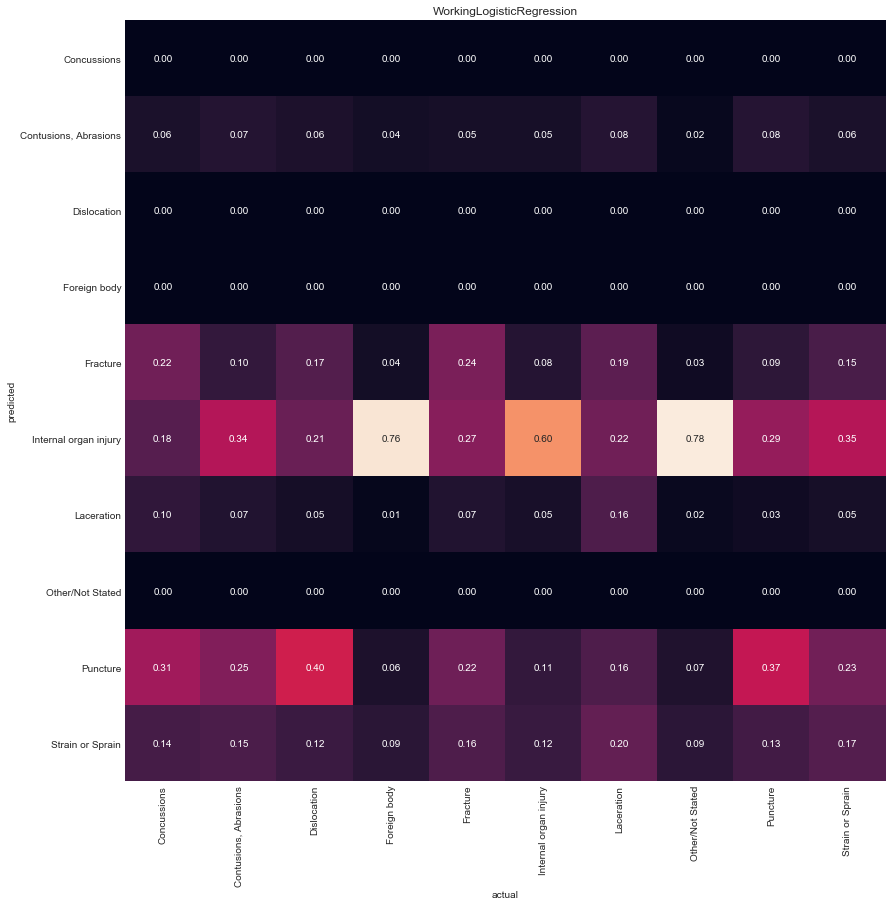

,target_class,predicted_class,Other/Not Stated,Fracture,"Contusions, Abrasions",Foreign body,Laceration,Internal organ injury,Strain or Sprain,Dislocation,Concussions,Puncture
0,Fracture,Strain or Sprain,0.0141,0.1824,0.0289,0.0043,0.1487,0.1112,0.0940,0.0026,0.2289,0.1849
1,Laceration,Laceration,0.0127,0.1608,0.0023,0.1164,0.1158,0.2849,0.0717,0.0173,0.0934,0.1246
2,Internal organ injury,Laceration,0.0128,0.1769,0.0158,0.0130,0.1332,0.1939,0.0845,0.0115,0.1686,0.1899
3,Fracture,Strain or Sprain,0.0158,0.1908,0.0353,0.0023,0.1622,0.0600,0.1097,0.0017,0.2402,0.1821
4,"Contusions, Abrasions",Strain or Sprain,0.0291,0.1867,0.0424,0.0021,0.1974,0.0612,0.1412,0.0016,0.2088,0.1297
...,...,...,...,...,...,...,...,...,...,...,...,...
142853,Fracture,Strain or Sprain,0.0214,0.1948,0.0253,0.0030,0.1690,0.0606,0.1022,0.0017,0.2693,0.1527
142854,Strain or Sprain,Strain or Sprain,0.0446,0.1323,0.0304,0.0021,0.1646,0.0895,0.0693,0.0019,0.3074,0.1580
142855,Laceration,"Contusions, Abrasions",0.0243,0.1844,0.0098,0.0184,0.1687,0.1609,0.1648,0.0062,0.0985,0.1640
142856,Strain or Sprain,"Contusions, Abrasions",0.0176,0.1925,0.0093,0.0203,0.1636,0.1402,0.1078,0.0065,0.1536,0.1887


In [38]:
if True == Includes.LogisticRegression:
    logisticRegression.showMissclassifiedSamples()
    logisticRegression.showAccuracy()
    logisticRegression.showConfusionMatrix()
    dfPredictedVersusActual = logisticRegression.getPredictedVersusActualDataframe()
    display(dfPredictedVersusActual)

- Analysis:  The data does not follow a logistic regression model

## Gaussian Naive Bayes (GaussianNB) - dataframe subset used


Can perform online updates to model parameters via partial_fit method. 

For details on algorithm used to update feature means and variance online, 

see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:


http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf


In [39]:
if True == Includes.GaussianNB:
    class WorkingGaussianNB():
        def __init__(self, outputFeature, categories, dfIdToCode, codeIdTranslator, verbose=False):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.df = dfIdToCode.copy()
            self.codeIdTranslator = codeIdTranslator
    
            self.categories.remove(outputFeature)
            # print('categories=', self.categories)
            
            # Build the Label encoder
            self.le = {}
            for col in self.df.columns:
                self.le[col] = preprocessing.LabelEncoder()
                self.le[col].fit(self.df[col].unique())

                if True == verbose:
                    print('{0:12s} => {1}'.format(col, self.le[col].classes_))

            self.y_test = self.df[self.outputFeature]
            self.y_labels = self.columnOutputValueIdToString(self.y_test.unique(), self.outputFeature)

        def columnOutputValueIdToString(self, y_values, column_name):
            target_dict = column_dictionary[column_name]

            dfValues = pd.DataFrame(y_values, columns=[column_name])
            self.codeIdTranslator._transform(dfValues, 'idToCode', column_name)
            return [target_dict[x] for x in dfValues[column_name]]

        def showPredicted(self):
            print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
                  .format(
                      self.df.shape[0],
                      (self.y_test != self.y_pred).sum(),
                      100*(1-(self.y_test != self.y_pred).sum()/self.df.shape[0])
            ))

        def showConfusionMatrix(self):
            fig, ax = plt.subplots(figsize=(14, 14))

            heatmap = WorkingHeatmap(title='WorkingGaussianNB',
                x_label='true label', y_label='predicted label',
                y_bottom_adjust=0.5, y_top_adjust=-0.5,
                normalize_columns=True)
        
            # This sets the yticks "upright" with 0, as opposed to sideways with 90.
            #plt.yticks(rotation=0)  # does not appear to be working...

            heatmap.plot(
                self.confusion_matrix.T, square=True, annot=True, fmt='.2f', cbar=False,
                ax=ax, xticklabels=self.y_labels, yticklabels=self.y_labels)

            plt.show() 


        def trainClassifier(self, show_predicted_versus_actual=True, show_confusion_matrices=True):
            # Drop categories with low scores
            categories = self.categories
            df = self.df

            # Train classifier
            gnb = GaussianNB()
            gnb.fit(
                df[categories].values,
                df[self.outputFeature])

            y_pred = gnb.predict(self.df[categories])
            self.y_pred = y_pred

            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred,)

In [40]:
if True == Includes.GaussianNB:
    gaussianNB = WorkingGaussianNB(
        output_choice,
        neissSubset.getCategories(),
        neissSubset.getIdToCodeDataframe(),
        neissSubset.getCodeIdTranslator())

In [41]:
if True == Includes.GaussianNB:
    gaussianNB.trainClassifier()

In [42]:
if True == Includes.GaussianNB:
    gaussianNB.showPredicted()

Number of mislabeled points out of a total 1000000 points : 719923, performance 28.01%


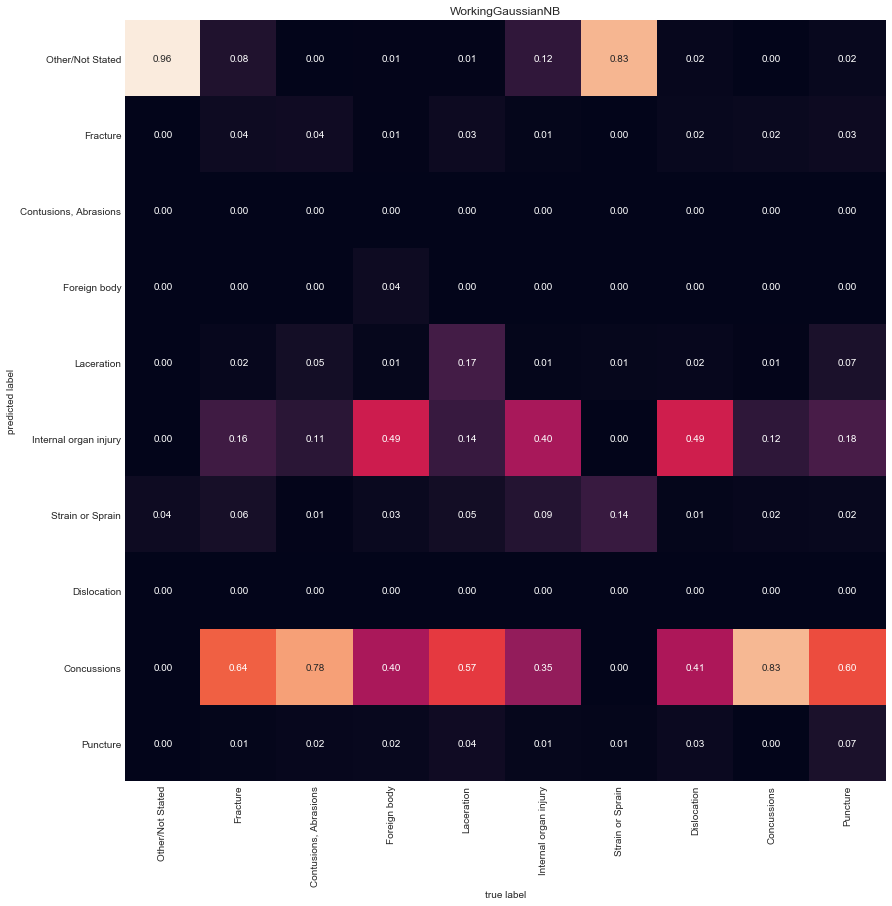

In [43]:
if True == Includes.GaussianNB:
    gaussianNB.showConfusionMatrix()


## Decision Tree - dataframe subset used

http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/

DecisionTreeClassifier(

    class_weight=None, criterion='gini', max_depth=None,
    
    max_features=None, max_leaf_nodes=None,
    
    min_impurity_split=1e-07, min_samples_leaf=1,
    
    min_samples_split=2, min_weight_fraction_leaf=0.0,
    
    presort=False, random_state=None, splitter='best')
            

- Analysis:  The GausianNB works better then either the Linear or Logistic Regressions.

In [ ]:
            #y = self.df[self.output_choice].to_frame(self.output_choice)
            #self.df = PrunerKBest(chi2, k_features=10).execute(self.df, y)
            #self.df[self.output_choice] = y[self.output_choice]


In [116]:
if True == Includes.DecisionTree:
    class WorkingDecisionTree():
        def __init__(self, df, output_choice, dataframe_pruner=None):
            self.df = df.copy()
            self.output_choice = output_choice

            if None != dataframe_pruner:
                self.df = dataframe_pruner.prune(self.df)

            # Remove columns containing NaN or columns where the number of unique items is greater than 
            toBeDropped = []
            for col in self.df.columns:
                if self.df[col].isnull().values.any():
                    toBeDropped.append(col)


            # Also remove the case number and the narrative
            toBeDropped.extend(['CPSC_Case_Number', 'Narrative_1', 'Stratum'])

            # The following dates (1999 ... 2013) contain codes that do not match the column_codes table.
            self.df = self.df[~self.df['Treatment_Date'].dt.year.isin(list(range(1999, 2013)))]

            self.df.drop(toBeDropped, axis=1, inplace=True)

            # Remove values from dates (2014 ... 2018) that do not have column codes for them
            self.df = self.df[~self.df['Product_1'].isin([1841, 1903])]
            self.df = self.df[~self.df['Product_2'].isin([1841, 1903])]

            self.df['mDate'] = mdates.date2num(self.df['Treatment_Date']) 
            self.df.drop(['Treatment_Date'], axis=1, inplace=True)

            # Figure out which of the inputs are the best to use
            #self.df.dropna(axis=1, inplace=True)
            #y = self.df[self.output_choice].to_frame(self.output_choice)
            #self.dfPruned = PrunerKBest(chi2, k_features=10).execute(self.df, y)
            #self.dfPruned[self.output_choice] = y[self.output_choice]
            #display(self.dfPruned)
            #print(type(self.dfPruned))
            ##WorkingDecisionTree.testNull(self.dfPruned, 'self.dfPruned')

            self.dfDecisionTree = Neiss.translateCodesToIds(self.df)

            self.replaceValueWithStringInColumn(self.dfDecisionTree, 'Product_1', 0, 'Zero') # Keep the zero.
            self.replaceValueWithStringInColumn(self.dfDecisionTree, 'Product_2', 0, 'Zero') # Especially for Product_2.
            self.replaceValueWithStringInColumn(self.dfDecisionTree, 'Fire_Involvement', 4, 'InvalidCode')


            #self.checkForNumericValueInColumn(self.dfDecisionTree, 'Disposition')
            self.checkForNumericValueInColumn(self.dfDecisionTree, 'Fire_Involvement')
            self.checkForNumericValueInColumn(self.dfDecisionTree, 'Product_1')
            self.checkForNumericValueInColumn(self.dfDecisionTree, 'Product_2')

            self.dfOneHot = WorkingDecisionTree.transformToOneHotEncodedDataframe(self.dfDecisionTree)
            #print('dfOneHot.shape =', self.dfOneHot.shape)
            #print('dfOneHot.columns =', self.dfOneHot.columns)

            self.y_labels_org = self.columnOutputValueCodeToString(
                self.df[self.output_choice].unique(),
                self.output_choice)

            self.y_labels = []
            for col_value in self.dfOneHot.columns:
                if col_value[0] == self.output_choice:
                    self.y_labels.append(col_value)

            self.x_labels = [value for value in self.dfOneHot.columns if value not in self.y_labels]
            self.x = self.dfOneHot[self.x_labels]
            self.y = self.dfOneHot[self.y_labels]
            #print('x_labels =', self.x_labels)
            #print('x.shape =', self.x.shape)
            #print('y.shape =', self.y.shape)

            #print()
            #for col in self.dfDecisionTree.columns:
            #    print('{:20s}\tnunique={}\tnum_nulls={}\ttype={}'.format(
            #        col,
            #        self.dfDecisionTree[col].nunique(),
            #        self.dfDecisionTree[col].isnull().sum(),
            #        self.dfDecisionTree[col].dtype))

            print('Done')

        def testNull(obj, name):
            if pd.isnull(obj).any():
                raise Exception('Exception: {} is null'.format(name))

        def showConfusionMatrix(self):
            fig, ax = plt.subplots(figsize=(14, 14))

            heatmap = WorkingHeatmap(title='WorkingDecisionTree',
                x_label='true label', y_label='predicted label',
                y_bottom_adjust=0.5, y_top_adjust=-0.5,
                normalize_columns=True)
        
            # This sets the yticks "upright" with 0, as opposed to sideways with 90.
            #plt.yticks(rotation=0)  # does not appear to be working...

            heatmap.plot(
                self.confusion_matrix.T, square=True, annot=True, fmt='.2f', cbar=False,
                ax=ax, xticklabels=self.y_labels, yticklabels=self.y_labels)

            plt.show() 

        def columnOutputValueCodeToString(self, y_values, column_name):
            target_dict = column_dictionary[column_name]

            dfValues = pd.DataFrame(y_values, columns=[column_name])
            return [target_dict[x] for x in dfValues[column_name]]

        def fullTestTrainAccuracy(self, criterion='gini', graph_viz=False, out_file=None, render_name=None):
            # gini is the default criterion

            clfDecisionTree = DecisionTreeClassifier(criterion=criterion)
            clfDecisionTreeFit = clfDecisionTree.fit(self.x, self.y)
            y_pred = clfDecisionTreeFit.predict(self.x)
            self.y_labels = self.y_labels_org

            self.y_test = self.columnOutputValueCodeToString(
                self.df[self.output_choice], self.output_choice)

            display(y_pred)
            display(self.y.columns)
            dfPredY = pd.DataFrame(y_pred, columns=self.y.columns)
            dfPredY = WorkingDecisionTree.transformFromOneHotEncodedDataframe(dfPredY)
            self.y_pred = dfPredY[self.output_choice]
            display(self.y_pred)
            WorkingDecisionTree.testNull(self.y_test, 'self.y_test')
            WorkingDecisionTree.testNull(self.y_pred, 'self.y_pred')

            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred)

            # Model accuracy
            accuracy = metrics.accuracy_score(self.y, y_pred)
            print('Accuracy =', accuracy)

            # This code generates the following error for some reason:
            #    Error: neiss_2013_2018: syntax error in line 743 near ','
            if True == graph_viz:
                dot_data = export_graphviz(
                    clfDecisionTreeFit, out_file=out_file, 
                    feature_names = self.x_labels,    # inputs
                    class_names   = self.y_labels,    # outputs 
                    filled=True, rounded=True,   
                    special_characters=True)  

                graph = graphviz.Source(dot_data) 
                if None != render_name:
                    graph.render(render_name)

        def _runClassifier(self, classifier, X_test, y_test):
            y_pred = classifier.predict(X_test)

            dfTestY = WorkingDecisionTree.transformFromOneHotEncodedDataframe(self.y_test)
            
            dfPredY = pd.DataFrame(y_pred, columns=self.y_test.columns)
            dfPredY = WorkingDecisionTree.transformFromOneHotEncodedDataframe(dfPredY)
            
            self.y_test = dfTestY[self.output_choice]
            self.y_pred = dfPredY[self.output_choice]


            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred)
            self.y_labels = self.y_test.unique()
                        
            #print('self.y_test')
            #display(self.y_test)
            #print('self.y_pred')
            #display(self.y_pred)
            
            # Model accuracy
            accuracy = metrics.accuracy_score(y_test, y_pred)
            print('Accuracy =', accuracy)

            # This code generates the following error for some reason:
            #    Error: neiss_2013_2018: syntax error in line 743 near ','
            if True == graph_viz:
                dot_data = export_graphviz(
                    clfDecisionTreeFit, out_file=out_file, 
                    feature_names = self.x_labels,    # inputs
                    class_names   = self.y_labels,    # outputs 
                    filled=True, rounded=True,   
                    special_characters=True)  

                graph = graphviz.Source(dot_data) 
                if None != render_name:
                    graph.render(render_name)

        def splitTestTrainAccuracy(self, 
            criterion='gini', random_state=1, test_size=0.3,
            graph_viz=False, out_file=None, render_name=None):

            X_train, X_test, y_train, y_test = train_test_split(
                self.x, self.y, test_size=0.3, random_state=bu_id)
            self.y_test = y_test

            clfDecisionTree = DecisionTreeClassifier(criterion=criterion)
            clfDecisionTreeFit = clfDecisionTree.fit(X_train, y_train)
            print(clfDecisionTreeFit)

            self._runClassifier(clfDecisionTreeFit, X_test, y_test)

        def gridSearch(self, random_state=1, test_size=0.3,
            graph_viz=False, out_file=None, render_name=None):

            # http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/

            #DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            #            max_features=None, max_leaf_nodes=None,
            #            min_impurity_split=1e-07, min_samples_leaf=1,
            #            min_samples_split=2, min_weight_fraction_leaf=0.0,
            #            presort=False, random_state=None, splitter='best')

            tree_parameters = {
                'criterion' : ['gini','entropy'],
                'min_samples_split' : [2, 4, 8, 16, 32, 64, 128],
                'max_depth' : [16, 32, 64, 128, 256]
            }

            X_train, X_test, y_train, y_test = train_test_split(
                self.x, self.y, test_size=0.3, random_state=bu_id)
            self.y_test = y_test

            #print('X_train')
            #display(X_train)
            #print('y_train')
            #display(y_train)

            clfDecisionTree = GridSearchCV(DecisionTreeClassifier(), tree_parameters, cv=5)
            clfDecisionTreeFit = clfDecisionTree.fit(X_train, y_train)
            print(clfDecisionTreeFit)

            self._runClassifier(clfDecisionTreeFit, X_test, y_test)
            # num_leafs = [1, 5, 10, 20, 50, 100]
            
        def replaceValueWithStringInColumn(self, df, column_name, replace_value, with_string):
            try:
                df[column_name] = [
                    with_string if str(x) == '{}'.format(replace_value) else x 
                    for x in df[column_name]]  # Replace zeros in col='disposition' with 'Unknown'
            except:
                pass

        def checkForNumericValueInColumn(self, df, columnName):
            try:
                for index, value in enumerate(df[columnName]):
                    if type(value) == int:
                        if 'Treatment_Date' in df.columns:
                            print('{}: Found int={} at {} - {}'.format(
                                columnName, value, index, df['Treatment_Date'].iloc[index]))
                        else:
                            print('{}: Found int={} at {}'.format(columnName, value, index))
            except:
                pass
                
        def transformFromOneHotEncodedDataframe(df):
            df1 = df.copy()
            
            columns = df.columns
            for col in df.columns:
                (column_name, value) = col
                
                if column_name not in df1.columns:
                    df1[column_name] = np.nan
    
                is_set = (1 == df[col])
                df1[column_name][is_set] = value

            df1.drop(columns, axis=1, inplace=True)

            return df1

        def transformToOneHotEncodedDataframe(df):
            '''
            Take columns that are objects and turn them into multiple one-hot columns.

            Args:
                df    (pd.DataFrame):  The dataframe to convert to a one-hot dataframe

            Returns:
                dfOneHot (pd.DataFrame):  A dataframe with the original objects replaced with one-hot versions.


            Example dataframe:

                Cost(dollars)  Item
                2              'Baseball'
                5              'Baseball Glove'
                7              'Helmet'

            Will become a dataframe similar to:

                Cost(dollars)  ('Item', 'Baseball')    ('Item', 'Baseball Glove')  ('Item', 'Helmet)
                2              1                       0                           0
                5              0                       1                           0
                7              0                       0                           1

            By making a tuple for the column header it is easy to determine the variable that the one-hot
            column represents.
            '''
            dfOneHot = df.copy()

            updateFreq = 100
            print('Dots are printed every {} translations during one-hot transformation'.format(updateFreq))

            for col in df.columns:
                if df[col].dtype == object:
                    print('One-hot transforming {:20s}'.format(col), end='\t')

                    unique = pd.unique(df[col].sort_values(ascending=True))
                    nUnique = len(unique)
                    print('nUnique={}'.format(nUnique), end='\t')

                    updateIndex = updateFreq
                    updateNext = updateFreq

                    for index, value in enumerate(unique):
                        if index == updateIndex:
                            updateIndex += updateFreq
                            updateNext += updateFreq
                            print('.', end='')

                        dfOneHot[(col, value)] = (dfOneHot[col] == value).astype(int)
                    dfOneHot.drop(columns=[col], inplace=True)
                    print('\tcomplete')
            return dfOneHot

        

In [117]:
if True == Includes.DecisionTree:
    df = neiss.getDataFrame()
    # max_output_rows = 1000000
    # max_output_rows = 20000
    # max_output_rows = 10000
    max_output_rows = 5000
    # max_output_rows = 100
    # max_output_rows = len(df) // 4
    pruner = DataFramePruner(dict_prune={output_choice : 10}, max_output_rows=max_output_rows)
        
    decisionTree = WorkingDecisionTree(df, output_choice, pruner)

Dots are printed every 100 translations during one-hot transformation
One-hot transforming Sex                 	nUnique=2		complete
One-hot transforming Race                	nUnique=7		complete
One-hot transforming Body_Part           	nUnique=24		complete
One-hot transforming Diagnosis           	nUnique=10		complete
One-hot transforming Disposition         	nUnique=6		complete
One-hot transforming Location            	nUnique=8		complete
One-hot transforming Fire_Involvement    	nUnique=3		complete
One-hot transforming Product_1           	nUnique=355	...	complete
One-hot transforming Product_2           	nUnique=166	.	complete
Done


- ***** 
- Full with 100% training set, 100% testing set
- ***** 

In [118]:
if True == Includes.DecisionTree:
    render_name='neiss_full'
    graph_viz=False
    decisionTree.fullTestTrainAccuracy(graph_viz=graph_viz, render_name=render_name)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

Index([          ('Diagnosis', 'Concussions'),
       ('Diagnosis', 'Contusions, Abrasions'),
                 ('Diagnosis', 'Dislocation'),
                ('Diagnosis', 'Foreign body'),
                    ('Diagnosis', 'Fracture'),
       ('Diagnosis', 'Internal organ injury'),
                  ('Diagnosis', 'Laceration'),
            ('Diagnosis', 'Other/Not Stated'),
                    ('Diagnosis', 'Puncture'),
            ('Diagnosis', 'Strain or Sprain')],
      dtype='object')

/Users/mcorbett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0       Internal organ injury
1                  Laceration
2       Contusions, Abrasions
3                 Concussions
4                 Dislocation
                ...          
4995               Laceration
4996                 Fracture
4997               Laceration
4998         Strain or Sprain
4999               Laceration
Name: Diagnosis, Length: 5000, dtype: object

Accuracy = 1.0


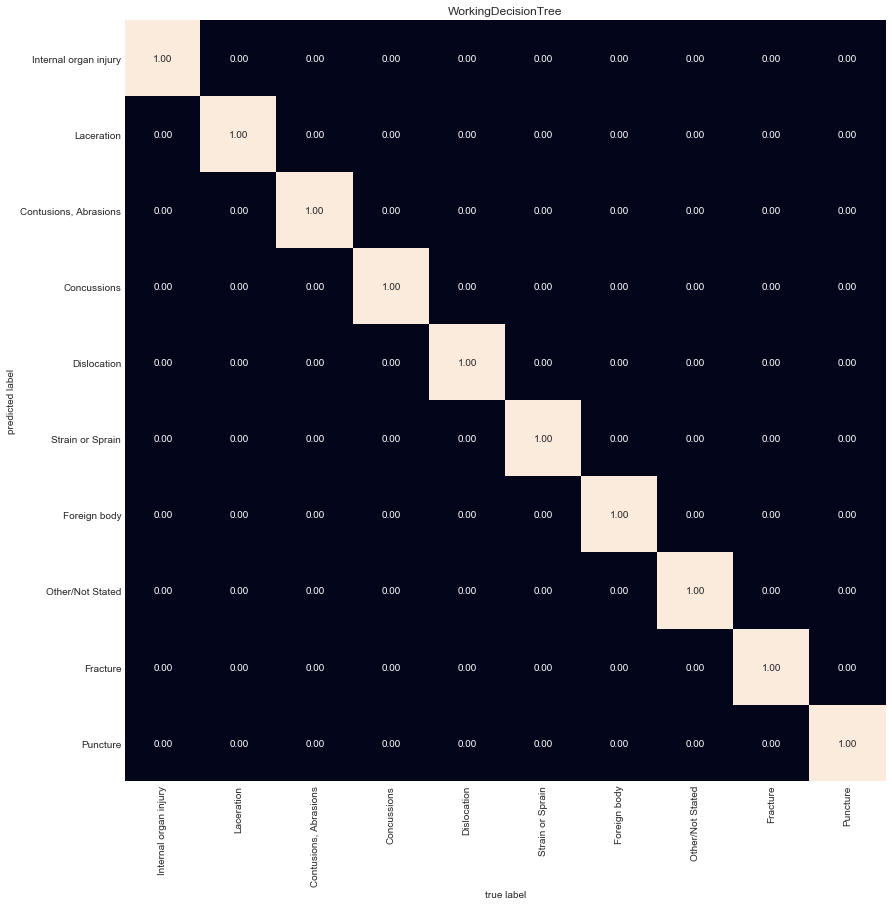

In [119]:
if True == Includes.DecisionTree:
    decisionTree.showConfusionMatrix()

In [ ]:
if True == Includes.DecisionTree:
    if True == graph_viz:
        !open '{}.pdf'.format(render_name)

- ***** 
- Now with 70% training set, 30% testing set
- ***** 

In [120]:
if True == Includes.DecisionTree:
    bu_id = 7286
    render_name='neiss_70_30_split'
    graph_viz=False
    decisionTree.splitTestTrainAccuracy(
        criterion='gini', graph_viz=graph_viz, render_name=render_name, 
        test_size=0.3, random_state=bu_id)                 


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy = 0.46


/Users/mcorbett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


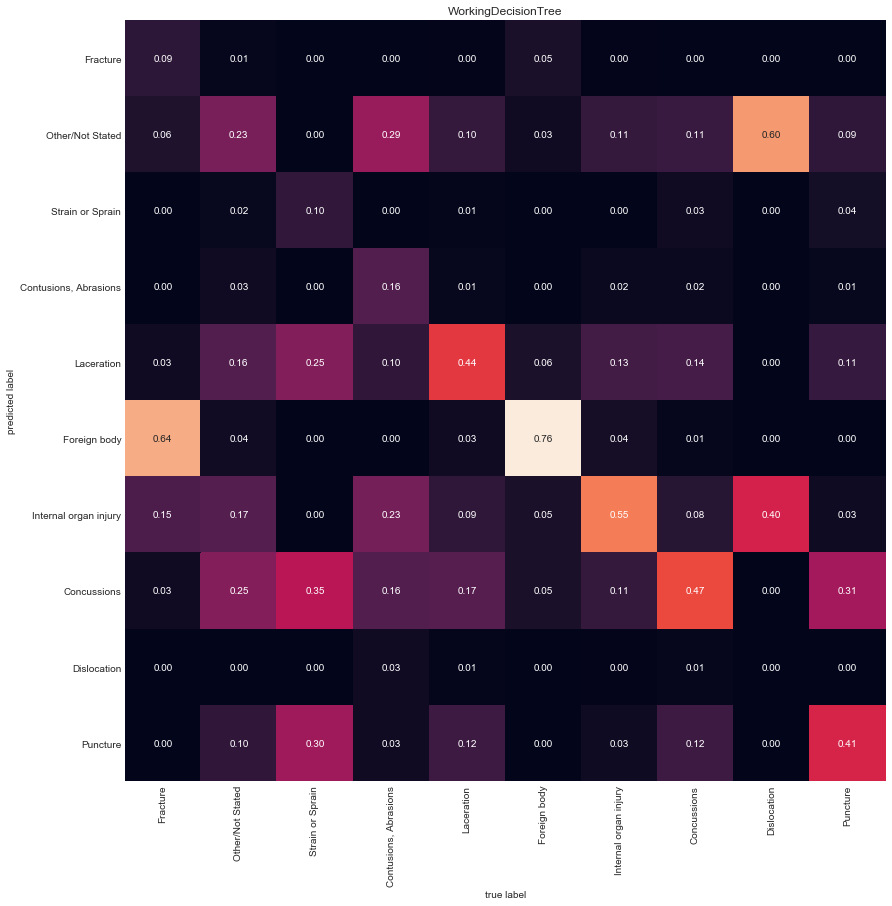

In [121]:
if True == Includes.DecisionTree:
    decisionTree.showConfusionMatrix()

In [ ]:
if True == Includes.DecisionTree:
    if True == graph_viz:
        !open '{}.pdf'.format(render_name)

### Now using GridSearchCV

In [122]:
if True == Includes.DecisionTree:
    bu_id = 7286
    render_name='neiss_grid_search_cv'
    graph_viz=False
    decisionTree.gridSearch(graph_viz=graph_viz, render_name=render_name, test_size=0.3, random_state=bu_id)                 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 32, 64, 128, 256],
               

/Users/mcorbett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


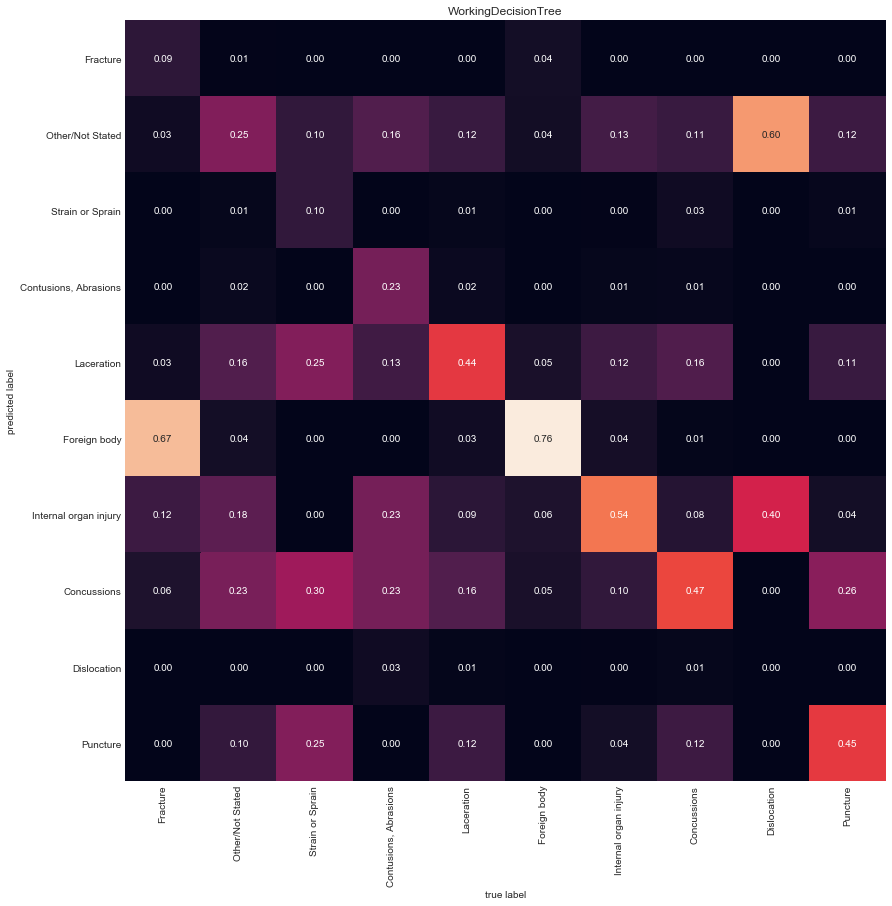

In [123]:
if True == Includes.DecisionTree:
    decisionTree.showConfusionMatrix()

In [ ]:
if True == Includes.DecisionTree:
    if True == graph_viz:
        !open '{}.pdf'.format(render_name)

- Analysis:  The DecisionTree looks like it is taking shape.  The accurracy is upto 50%.  Unfortunately, feeding more rows into the dataframe causes a NaN error.  Running out of memory?
    

## LDA (fit based on class) / Support Vector Machines (SVM) / Pipeline

In [ ]:
if True == Includes.LdaSvmPipeline:
    class WorkingLdaSvmPipeline:
        def __init__(self, 
                     outputFeature, categories, dfIdToCode, 
                     codeIdTranslator, max_iter=5000,
                     dataframe_pruner=None):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.df = dfIdToCode.copy()
            self.codeIdTranslator = codeIdTranslator
        
            self.categories.remove(self.outputFeature)
    
            if None != dataframe_pruner:
                self.df = dataframe_pruner.prune(self.df)
                
            self.inputs = self.df[self.categories]
            self.output = self.df[self.outputFeature]
            
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                self.inputs, self.output, test_size=1/7.0, random_state=122)

            # Standardize the data
            self.scaler = StandardScaler()
            
            # --- --- ---

            n_components=self.y_test.nunique()
            print('n_components=', n_components)
            
            lda_tree_parameters = {
                'n_components' : [n_components],
            }            
            self.clfLdaGridCV = GridSearchCV(LinearDiscriminantAnalysis(), lda_tree_parameters, cv=5)

            # --- --- ---

            svc_tree_parameters = {
                'kernel'       : ['rbf'],
                'C'            : [1000, 1E6],
                'gamma'        : ['auto'],
                'class_weight' : ['balanced']
                
            }            
            self.clfSvcGridCV = GridSearchCV(SVC(), svc_tree_parameters, cv=5)
            
            # --- --- ---

            self.model = Pipeline([
                ('scaler', self.scaler),
                ('lda', self.clfLdaGridCV),
                ('svc', self.clfSvcGridCV)
                ])

            print('Model built')

        def columnOutputValueIdToString(self, y_values, column_name):
            target_dict = column_dictionary[column_name]

            dfValues = pd.DataFrame(y_values, columns=[column_name])
            self.codeIdTranslator._transform(dfValues, 'idToCode', column_name)
            return [target_dict[x] for x in dfValues[column_name]]

        def compute(self):
            self.model.fit(self.x_train, self.y_train)
            self.y_pred = self.model.predict(self.x_test)

            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred)
            self.y_labels = self.y_test.unique()
            
            self.y_labels = self.columnOutputValueIdToString(self.y_labels, self.outputFeature)

            # Model accuracy
            accuracy = metrics.accuracy_score(self.y_test, self.y_pred)
            print('Accuracy =', accuracy)

        def testNull(obj, name):
            if pd.isnull(obj).any():
                raise Exception('Exception: {} is null'.format(name))

        def showConfusionMatrix(self):
            fig, ax = plt.subplots(figsize=(14, 14))

            heatmap = WorkingHeatmap(title='WorkingDecisionTree',
                x_label='true label', y_label='predicted label',
                y_bottom_adjust=0.5, y_top_adjust=-0.5,
                normalize_columns=True)
        
            # This sets the yticks "upright" with 0, as opposed to sideways with 90.
            #plt.yticks(rotation=0)  # does not appear to be working...

            heatmap.plot(
                self.confusion_matrix.T, square=True, annot=True, fmt='.2f', cbar=False,
                ax=ax, xticklabels=self.y_labels, yticklabels=self.y_labels)

            plt.show() 


In [ ]:
if True == Includes.LdaSvmPipeline:
    max_output_rows = 5000
    # max_output_rows = len(df) // 4
    
    pruner = DataFramePruner(
        dict_prune={output_choice : 10}, 
        max_output_rows=max_output_rows)

    ldaSvmPipeline = WorkingLdaSvmPipeline(
        output_choice,
        neissSubset.getCategories(),
        neissSubset.getIdToCodeDataframe(),
        neissSubset.getCodeIdTranslator(),
        max_iter=100,
        dataframe_pruner=pruner)


In [ ]:
if True == Includes.LdaSvmPipeline:
    ldaSvmPipeline.compute()


In [ ]:
if True == Includes.LdaSvmPipeline:
    ldaSvmPipeline.showConfusionMatrix()

- Analysis:  For the same size dataset the DecisionTree appears to be faaster than the Scaler, LDA,SVM pipeline and provides better classification.